In [1]:
"""

create linear regression model for
target of US county 2019 median household income
and features gathered from multiple sources plus web scraping

Use Log transformed target 

5 Kfold cross-validation

Same test set as held out with previous model fits

Add feature engineering for 
unemp^2
civ LF ^2
unemp * civ LF
ru_1 * civ LF
recreation * civ LF

FINAL MODEL
RUN RIDGE REGULARIZATION

SCORE ON TEST HOLD OUT SET

"""

'\n\ncreate linear regression model for\ntarget of US county 2019 median household income\nand features gathered from multiple sources plus web scraping\n\nMODEL 3:  Use Log transformed target \nadd some interaction terms to see if these help R2\n\nDO all preprocessing first \nExamine if better to split metro and non-metro models\n\n'

In [1]:
import pickle
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt

import scipy.stats as stats

In [2]:
with open('county_model_data.pickle', 'rb') as read_file:
    model_data = pickle.load(read_file)
    
model_data.head()

,FIPS_code,Stabr,area_name,Area_Name,Median_Household_Income_2019,Civilian_labor_force_2019,Unemployment_rate_2019,hwy_count,city_town_counts,Metro_2013,...,Farming_2015_Update,Mining_2015-Update,Manufacturing_2015_Update,Government_2015_Update,Recreation_2015_Update,Nonspecialized_2015_Update,Low_Education_2015_Update,Low_Employment_Cnty_2008_2012_25_64,Retirement_Dest_2015_Update,Persistent_Poverty_2013
0,01001,AL,"Autauga County, AL",Autauga County,58233.0,26172.0,2.7,6.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,01003,AL,"Baldwin County, AL",Baldwin County,59871.0,97328.0,2.7,12.0,14.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,01005,AL,"Barbour County, AL",Barbour County,35972.0,8537.0,3.8,11.0,6.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
3,01007,AL,"Bibb County, AL",Bibb County,47918.0,8685.0,3.1,8.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,01009,AL,"Blount County, AL",Blount County,52902.0,25331.0,2.7,9.0,16.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [3]:
model_data.columns

Index(['FIPS_code', 'Stabr', 'area_name', 'Area_Name',
       'Median_Household_Income_2019', 'Civilian_labor_force_2019',
       'Unemployment_rate_2019', 'hwy_count', 'city_town_counts', 'Metro_2013',
       'Rural_urban_continuum_code_2013', 'Farming_2015_Update',
       'Mining_2015-Update', 'Manufacturing_2015_Update',
       'Government_2015_Update', 'Recreation_2015_Update',
       'Nonspecialized_2015_Update', 'Low_Education_2015_Update',
       'Low_Employment_Cnty_2008_2012_25_64', 'Retirement_Dest_2015_Update',
       'Persistent_Poverty_2013'],
      dtype='object')

In [4]:
# DO all preprocessing on whole DF before split
# log transform civilian labor force
model_data['log_Civilian_LF'] = np.log(model_data['Civilian_labor_force_2019'])

model_data.head()

,FIPS_code,Stabr,area_name,Area_Name,Median_Household_Income_2019,Civilian_labor_force_2019,Unemployment_rate_2019,hwy_count,city_town_counts,Metro_2013,...,Mining_2015-Update,Manufacturing_2015_Update,Government_2015_Update,Recreation_2015_Update,Nonspecialized_2015_Update,Low_Education_2015_Update,Low_Employment_Cnty_2008_2012_25_64,Retirement_Dest_2015_Update,Persistent_Poverty_2013,log_Civilian_LF
0,01001,AL,"Autauga County, AL",Autauga County,58233.0,26172.0,2.7,6.0,4.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,10.172445
1,01003,AL,"Baldwin County, AL",Baldwin County,59871.0,97328.0,2.7,12.0,14.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,11.485842
2,01005,AL,"Barbour County, AL",Barbour County,35972.0,8537.0,3.8,11.0,6.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,9.052165
3,01007,AL,"Bibb County, AL",Bibb County,47918.0,8685.0,3.1,8.0,5.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,9.069353
4,01009,AL,"Blount County, AL",Blount County,52902.0,25331.0,2.7,9.0,16.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,10.139784


In [5]:
# one hot encoding for Rural_urban_continuum_code_2013

ru_code = model_data[['Rural_urban_continuum_code_2013']]

one = OneHotEncoder(sparse=False)
one.fit(ru_code)
cats = one.transform(ru_code)

columns = one.get_feature_names(['Rural_urban_continuum_code_2013'])
ru_code_df = pd.DataFrame(cats, columns=columns, index=ru_code.index)

# drop the last column, so model intercept becomes about rural areas

X_train_ru_df2 =  ru_code_df.iloc[ :, :-1]
X_train_ru_df2.head()


,Rural_urban_continuum_code_2013_1.0,Rural_urban_continuum_code_2013_2.0,Rural_urban_continuum_code_2013_3.0,Rural_urban_continuum_code_2013_4.0,Rural_urban_continuum_code_2013_5.0,Rural_urban_continuum_code_2013_6.0,Rural_urban_continuum_code_2013_7.0,Rural_urban_continuum_code_2013_8.0
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
proc_data = pd.concat([model_data, X_train_ru_df2], axis=1)


proc_data.head()

,FIPS_code,Stabr,area_name,Area_Name,Median_Household_Income_2019,Civilian_labor_force_2019,Unemployment_rate_2019,hwy_count,city_town_counts,Metro_2013,...,Persistent_Poverty_2013,log_Civilian_LF,Rural_urban_continuum_code_2013_1.0,Rural_urban_continuum_code_2013_2.0,Rural_urban_continuum_code_2013_3.0,Rural_urban_continuum_code_2013_4.0,Rural_urban_continuum_code_2013_5.0,Rural_urban_continuum_code_2013_6.0,Rural_urban_continuum_code_2013_7.0,Rural_urban_continuum_code_2013_8.0
0,01001,AL,"Autauga County, AL",Autauga County,58233.0,26172.0,2.7,6.0,4.0,1.0,...,0.0,10.172445,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01003,AL,"Baldwin County, AL",Baldwin County,59871.0,97328.0,2.7,12.0,14.0,1.0,...,0.0,11.485842,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,01005,AL,"Barbour County, AL",Barbour County,35972.0,8537.0,3.8,11.0,6.0,0.0,...,1.0,9.052165,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,01007,AL,"Bibb County, AL",Bibb County,47918.0,8685.0,3.1,8.0,5.0,1.0,...,0.0,9.069353,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,01009,AL,"Blount County, AL",Blount County,52902.0,25331.0,2.7,9.0,16.0,1.0,...,0.0,10.139784,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
proc_data.columns

Index(['FIPS_code', 'Stabr', 'area_name', 'Area_Name',
       'Median_Household_Income_2019', 'Civilian_labor_force_2019',
       'Unemployment_rate_2019', 'hwy_count', 'city_town_counts', 'Metro_2013',
       'Rural_urban_continuum_code_2013', 'Farming_2015_Update',
       'Mining_2015-Update', 'Manufacturing_2015_Update',
       'Government_2015_Update', 'Recreation_2015_Update',
       'Nonspecialized_2015_Update', 'Low_Education_2015_Update',
       'Low_Employment_Cnty_2008_2012_25_64', 'Retirement_Dest_2015_Update',
       'Persistent_Poverty_2013', 'log_Civilian_LF',
       'Rural_urban_continuum_code_2013_1.0',
       'Rural_urban_continuum_code_2013_2.0',
       'Rural_urban_continuum_code_2013_3.0',
       'Rural_urban_continuum_code_2013_4.0',
       'Rural_urban_continuum_code_2013_5.0',
       'Rural_urban_continuum_code_2013_6.0',
       'Rural_urban_continuum_code_2013_7.0',
       'Rural_urban_continuum_code_2013_8.0'],
      dtype='object')

In [8]:
# log tranform target
proc_data['log_med_inc'] = np.log(proc_data['Median_Household_Income_2019'])


In [9]:
# add feature engineering

proc_data['unemp_sqrd'] = proc_data['Unemployment_rate_2019']**2

proc_data['log_civ_LF_sqrd'] = proc_data['log_Civilian_LF']**2

proc_data['unemp*civ_LF'] = proc_data['Unemployment_rate_2019'] * proc_data['log_Civilian_LF']

proc_data['ru1*civ_LF'] = proc_data['Rural_urban_continuum_code_2013_1.0'] * proc_data['log_Civilian_LF']

proc_data['rec*civ_LF'] = proc_data['Recreation_2015_Update'] * proc_data['log_Civilian_LF']

In [10]:
proc_data.columns

Index(['FIPS_code', 'Stabr', 'area_name', 'Area_Name',
       'Median_Household_Income_2019', 'Civilian_labor_force_2019',
       'Unemployment_rate_2019', 'hwy_count', 'city_town_counts', 'Metro_2013',
       'Rural_urban_continuum_code_2013', 'Farming_2015_Update',
       'Mining_2015-Update', 'Manufacturing_2015_Update',
       'Government_2015_Update', 'Recreation_2015_Update',
       'Nonspecialized_2015_Update', 'Low_Education_2015_Update',
       'Low_Employment_Cnty_2008_2012_25_64', 'Retirement_Dest_2015_Update',
       'Persistent_Poverty_2013', 'log_Civilian_LF',
       'Rural_urban_continuum_code_2013_1.0',
       'Rural_urban_continuum_code_2013_2.0',
       'Rural_urban_continuum_code_2013_3.0',
       'Rural_urban_continuum_code_2013_4.0',
       'Rural_urban_continuum_code_2013_5.0',
       'Rural_urban_continuum_code_2013_6.0',
       'Rural_urban_continuum_code_2013_7.0',
       'Rural_urban_continuum_code_2013_8.0', 'log_med_inc', 'unemp_sqrd',
       'log_civ_LF_sqr

In [11]:
proc_data.head()

,FIPS_code,Stabr,area_name,Area_Name,Median_Household_Income_2019,Civilian_labor_force_2019,Unemployment_rate_2019,hwy_count,city_town_counts,Metro_2013,...,Rural_urban_continuum_code_2013_5.0,Rural_urban_continuum_code_2013_6.0,Rural_urban_continuum_code_2013_7.0,Rural_urban_continuum_code_2013_8.0,log_med_inc,unemp_sqrd,log_civ_LF_sqrd,unemp*civ_LF,ru1*civ_LF,rec*civ_LF
0,01001,AL,"Autauga County, AL",Autauga County,58233.0,26172.0,2.7,6.0,4.0,1.0,...,0.0,0.0,0.0,0.0,10.972207,7.29,103.478646,27.465603,0.000000,0.000000
1,01003,AL,"Baldwin County, AL",Baldwin County,59871.0,97328.0,2.7,12.0,14.0,1.0,...,0.0,0.0,0.0,0.0,10.999948,7.29,131.924566,31.011773,0.000000,11.485842
2,01005,AL,"Barbour County, AL",Barbour County,35972.0,8537.0,3.8,11.0,6.0,0.0,...,0.0,1.0,0.0,0.0,10.490496,14.44,81.941690,34.398227,0.000000,0.000000
3,01007,AL,"Bibb County, AL",Bibb County,47918.0,8685.0,3.1,8.0,5.0,1.0,...,0.0,0.0,0.0,0.0,10.777246,9.61,82.253158,28.114993,9.069353,0.000000
4,01009,AL,"Blount County, AL",Blount County,52902.0,25331.0,2.7,9.0,16.0,1.0,...,0.0,0.0,0.0,0.0,10.876196,7.29,102.815224,27.377417,10.139784,0.000000


In [12]:
# split df 

X = proc_data[['Unemployment_rate_2019', 'hwy_count', 'city_town_counts', 'Metro_2013',
       'Farming_2015_Update', 'Mining_2015-Update',
       'Manufacturing_2015_Update', 'Government_2015_Update',
       'Recreation_2015_Update', 'Nonspecialized_2015_Update',
       'Low_Education_2015_Update', 'Low_Employment_Cnty_2008_2012_25_64',
       'Retirement_Dest_2015_Update', 'Persistent_Poverty_2013',
       'log_Civilian_LF', 'Rural_urban_continuum_code_2013_1.0',
       'Rural_urban_continuum_code_2013_2.0',
       'Rural_urban_continuum_code_2013_3.0',
       'Rural_urban_continuum_code_2013_4.0',
       'Rural_urban_continuum_code_2013_5.0',
       'Rural_urban_continuum_code_2013_6.0',
       'Rural_urban_continuum_code_2013_7.0',
       'Rural_urban_continuum_code_2013_8.0',
        'unemp_sqrd', 'log_civ_LF_sqrd', 
        'unemp*civ_LF', 'ru1*civ_LF', 'rec*civ_LF']]


y = proc_data['log_med_inc']


In [13]:
y[:10]

0    10.972207
1    10.999948
2    10.490496
3    10.777246
4    10.876196
5    10.370549
6    10.595234
7    10.773672
8    10.645782
9    10.736005
Name: log_med_inc, dtype: float64

In [14]:
X[:10]

,Unemployment_rate_2019,hwy_count,city_town_counts,Metro_2013,Farming_2015_Update,Mining_2015-Update,Manufacturing_2015_Update,Government_2015_Update,Recreation_2015_Update,Nonspecialized_2015_Update,...,Rural_urban_continuum_code_2013_4.0,Rural_urban_continuum_code_2013_5.0,Rural_urban_continuum_code_2013_6.0,Rural_urban_continuum_code_2013_7.0,Rural_urban_continuum_code_2013_8.0,unemp_sqrd,log_civ_LF_sqrd,unemp*civ_LF,ru1*civ_LF,rec*civ_LF
0,2.7,6.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,7.29,103.478646,27.465603,0.000000,0.000000
1,2.7,12.0,14.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7.29,131.924566,31.011773,0.000000,11.485842
2,3.8,11.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,14.44,81.941690,34.398227,0.000000,0.000000
3,3.1,8.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,9.61,82.253158,28.114993,9.069353,0.000000
4,2.7,9.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,7.29,102.815224,27.377417,10.139784,0.000000
5,3.6,6.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,12.96,71.912337,30.528411,0.000000,0.000000
6,3.6,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,12.96,83.425996,32.881620,0.000000,0.000000
7,3.5,11.0,9.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.25,115.367574,37.593255,0.000000,0.000000
8,2.9,7.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,8.41,93.401954,28.026959,0.000000,0.000000
9,2.9,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,8.41,87.592849,27.141405,0.000000,0.000000


In [15]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
# with log transform of target
# additional 5 engineered features

# arrays for KFold
X, y = np.array(X_train_val), np.array(y_train_val)

kf = KFold(n_splits=5, shuffle=True, random_state = 47)
cv_lm_r2s = [] #collect the validation results R2
cv_lm_rmse = [] #collect the validation RMSE


for train_ind, val_ind in kf.split(X, y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(round(lm.score(X_val, y_val), 3))
    
    y_pred = lm.predict(X_val)
    # log transformed target, need to put RMSE in original dollar terms 
    cv_lm_rmse.append(round(np.sqrt(mean_squared_error(np.exp(y_val), np.exp(y_pred))), 2))

print('Linear regression scores: ', cv_lm_r2s, '\n')

print(f'Mean CV r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}', '\n')

print(f'Linear regression RMSEs: ', cv_lm_rmse, '\n')

print(f'Mean CV RMSE:  {np.mean(cv_lm_rmse):.2f} +- {np.std(cv_lm_rmse):.2f}')

Linear regression scores:  [0.615, 0.64, 0.635, 0.602, 0.625] 

Mean CV r^2: 0.623 +- 0.014 

Linear regression RMSEs:  [9251.54, 9673.48, 9639.72, 8765.86, 8611.41] 

Mean CV RMSE:  9188.40 +- 436.91


Text(0, 0.5, 'residuals')

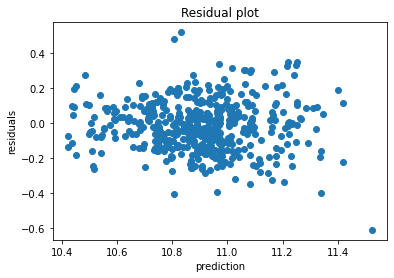

In [19]:
## last validation set residuals

y_pred = lm.predict(X_val)

res = y_val - y_pred
plt.scatter(y_pred, res)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

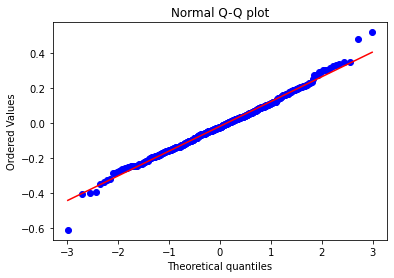

In [20]:
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [ ]:
###################################

In [ ]:
# run ridge regularization


In [21]:
# ridge on the LR, all training and validation data

m = RidgeCV()
s = StandardScaler()
X_train_scaled = s.fit_transform(X_train_val)

m.fit(X_train_scaled,y_train_val)
m.score(X_train_scaled,y_train_val)

0.6389857635096242

In [23]:
## FINAL MODEL
## SCORE ON TEST HOLD OUT SET

m.score(s.transform(X_test),y_test)

0.6423336115967313

In [31]:
# FINAL MODEL RMSE TEST SET
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))


9172.527973899421


In [25]:
## RESIDUALS FINAL MODEL TEST SET
y_pred = m.predict(s.transform(X_test))


Text(0, 0.5, 'residuals')

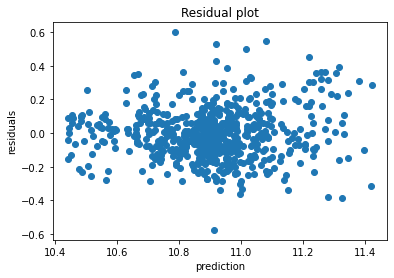

In [57]:
res = y_test - y_pred
plt.scatter(y_pred, res)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

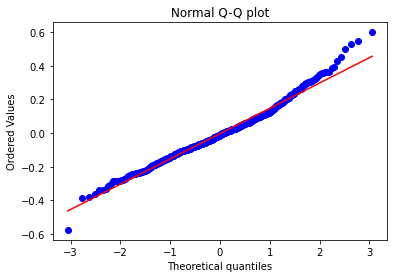

In [58]:
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

<ipython-input-83-1381559a2c0a>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes.set_xticklabels(['0', '40k','60k','80k','100k','120k'])
<ipython-input-83-1381559a2c0a>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes.set_yticklabels(['0', '40k','60k','80k','100k','120k'])


[Text(0, 20000.0, '0'),
 Text(0, 40000.0, '40k'),
 Text(0, 60000.0, '60k'),
 Text(0, 80000.0, '80k'),
 Text(0, 100000.0, '100k'),
 Text(0, 120000.0, '120k'),
 Text(0, 140000.0, '')]

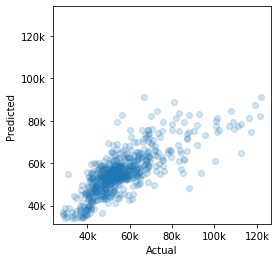

In [83]:
### plot actual vs. predicted

#y_predicted = lr.predict(X_test)

#y_actual = y_test


g=plt.scatter(np.exp(y_test), np.exp(y_pred), alpha=0.2)
#g.axes.set_yscale('log')
#g.axes.set_xscale('log')

g.axes.set_xlabel('Actual')
g.axes.set_ylabel('Predicted ')
g.axes.axis('equal')
g.axes.axis('square')

#g.axes.set_xticks(range(6))
g.axes.set_xticklabels(['0', '40k','60k','80k','100k','120k'])
g.axes.set_yticklabels(['0', '40k','60k','80k','100k','120k'])



In [33]:
# FINAL MODEL coefficients 
final_model_coef = sorted(list(zip(X_test.columns, m.coef_)))
final_model_coef